In [14]:
# Data Manipulation
import pandas as pd
import numpy as np

# Text Processing and NLP
import emoji
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

# Machine Learning
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report, accuracy_score, silhouette_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Download necessary NLTK data
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ngmin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# Feature Extraction - Without Stopwords

In [2]:
df = pd.read_csv("00_dataset/without_stopwords/cleaned_reviews.csv")
df.head()

,user_id,prod_id,review_text,rating,label,cleaned_text
0,5044,0,"Drinks were bad, the hot chocolate was watered...",1.0,1,"Drinks bad , hot chocolate water latte burnt t..."
1,5045,0,This was the worst experience I've ever had a ...,1.0,1,This bad experience I ever casual coffee/light...
2,5046,0,This is located on the site of the old Spruce ...,3.0,1,This locate site old Spruce St. Video . The mi...
3,5047,0,I enjoyed coffee and breakfast twice at Toast ...,5.0,1,I enjoy coffee breakfast twice Toast recent vi...
4,5048,0,I love Toast! The food choices are fantastic -...,5.0,1,I love Toast ! The food choice fantastic - I l...


In [3]:
print(df.isnull().sum())


user_id         0
prod_id         0
review_text     0
rating          0
label           0
cleaned_text    6
dtype: int64


In [4]:
df["cleaned_text"] = df["cleaned_text"].fillna("")

In [5]:
X = df["cleaned_text"]
y = df["label"]

# First, split into Train (80%) and Test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Next, split Train (80%) into Train (70%) and Validation (10%)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, stratify=y_train, random_state=42)

print("Training set: ", len(X_train))
print("Test set: ", len(X_test))
print("Validation set: ", len(X_val))

Training set:  425920
Test set:  121692
Validation set:  60846


In [7]:
vectorizer = TfidfVectorizer(max_features=5000)  # Top 5000 words
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

In [ ]:
import numpy as np
import joblib
import os
from sklearn.decomposition import IncrementalPCA

# Define settings
batch_size = 1000  # Adjust based on memory availability
checkpoint_file = "00_dataset/without_stopwords/pca/incremental_pca_checkpoint.joblib"  # Checkpoint filename

# Check if checkpoint exists to resume training
if os.path.exists(checkpoint_file):
    print("🔄 Resuming from last saved checkpoint...")
    ipca = joblib.load(checkpoint_file)
else:
    print("🚀 Starting new Incremental PCA...")
    ipca = IncrementalPCA()

# Fit PCA in batches and save model after each batch
for i in range(0, X_train_tfidf.shape[0], batch_size):
    batch = X_train_tfidf[i:i+batch_size].toarray()  # Convert only batch to dense if necessary
    ipca.partial_fit(batch)  # Update Incremental PCA model

    # Save model checkpoint after each batch
    joblib.dump(ipca, checkpoint_file)
    print(f"✅ Saved checkpoint after processing batch {i // batch_size + 1}")

print("🎉 Incremental PCA completed successfully!")

# Step 2: Compute Cumulative Explained Variance to Find Optimal n_components
cumulative_variance = np.cumsum(ipca.explained_variance_ratio_)

In [ ]:
# Plot cumulative explained variance
plt.figure(figsize=(10, 5))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid()
plt.show()

# Determine optimal number of components for 95% variance
optimal_n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components explaining 95% variance: {optimal_n_components}")

# Save the final model
final_model_file = "final_pca_model.joblib"
joblib.dump(ipca, final_model_file)
print("✅ Final Incremental PCA model saved successfully!")

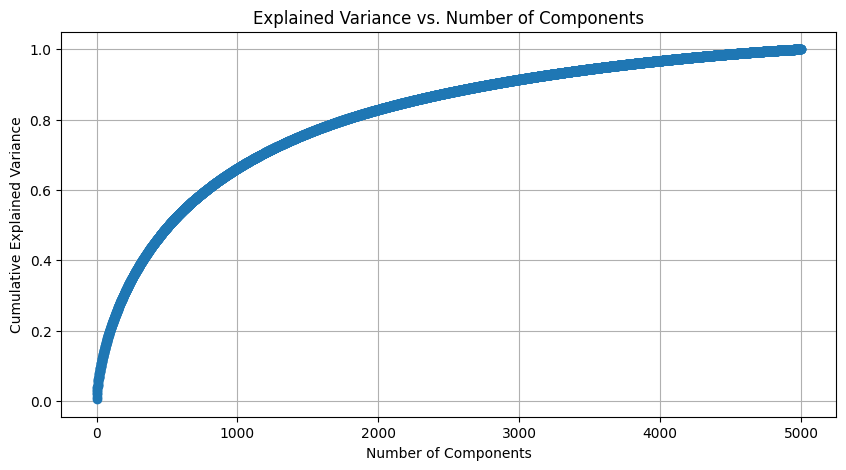

✅ Number of components explaining 95% variance: 3624
Optimal Number of Components: 3624


In [ ]:
import numpy as np
import joblib
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix

# Convert X_train_tfidf to a sparse matrix for efficiency
X_train_tfidf_sparse = csr_matrix(X_train_tfidf)

# Define maximum components (adjust based on dataset)
max_components = min(5000, X_train_tfidf.shape[1])  # Limit to 1000 or feature count

# Initialize Truncated SVD
svd = TruncatedSVD(n_components=max_components, random_state=42)

# Fit and transform data
X_train_svd = svd.fit_transform(X_train_tfidf_sparse)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(svd.explained_variance_ratio_)

# Plot cumulative explained variance
plt.figure(figsize=(10, 5))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid()
plt.show()

# Find the number of components that explain 95% variance
optimal_n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"✅ Number of components explaining 95% variance: {optimal_n_components}")

threshold = 0.95
if np.any(cumulative_variance >= threshold):
    optimal_n_components = np.argmax(cumulative_variance >= threshold) + 1
else:
    optimal_n_components = len(cumulative_variance)  # Take max available components
    print(f"⚠️ Warning: 95% variance not reached. Using {optimal_n_components} components instead.")

print(f"Optimal Number of Components: {optimal_n_components}")

# 🔹 Step 5: Retrain SVD with the Optimal Number of Components
svd = TruncatedSVD(n_components=optimal_n_components, random_state=42)
X_train_svd = svd.fit_transform(X_train_tfidf_sparse)

# 🔹 Step 6: Save Final SVD Model
joblib.dump(svd, "final_svd_model.joblib")
print("✅ Final Truncated SVD model saved successfully!")

Preprocessing 2 with sampling and pca

In [8]:
vectorizer = TfidfVectorizer(max_features=4000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf   = vectorizer.transform(X_val)
X_test_tfidf  = vectorizer.transform(X_test)
joblib.dump(vectorizer, "tfidf_vectorizer.joblib")
print("TF-IDF vectorizer saved.")

TF-IDF vectorizer saved.


In [15]:
optimal_n_components = 3624

# Initialize Truncated SVD
svd = TruncatedSVD(n_components=optimal_n_components, random_state=42)

# Convert TF-IDF to a sparse matrix (if not already sparse)
X_train_tfidf_sparse = csr_matrix(X_train_tfidf)
X_val_tfidf_sparse   = csr_matrix(X_val_tfidf)
X_test_tfidf_sparse  = csr_matrix(X_test_tfidf)

X_train_svd = svd.fit_transform(X_train_tfidf_sparse)
X_test_svd = svd.transform(X_test_tfidf)
X_val_svd = svd.transform(X_val_tfidf)

joblib.dump(svd, "final_svd_model.joblib")
print("Final Truncated SVD model saved.")

Final Truncated SVD model saved.


In [16]:
# Load your pre-saved final SVD model.
svd = joblib.load("final_svd_model.joblib")

# Check the number of components used
print("Optimal number of components:", svd.n_components)

# Compute the cumulative explained variance
cumulative_variance = np.cumsum(svd.explained_variance_ratio_)
print("Total variance explained:", cumulative_variance[-1])

Optimal number of components: 3624
Total variance explained: 0.9847818575770436


In [17]:
from scipy.sparse import csr_matrix

# Convert TF-IDF to a sparse matrix (if not already sparse)
X_train_tfidf_sparse = csr_matrix(X_train_tfidf)
X_val_tfidf_sparse   = csr_matrix(X_val_tfidf)
X_test_tfidf_sparse  = csr_matrix(X_test_tfidf)

X_train_svd = svd.transform(X_train_tfidf_sparse)
X_val_svd   = svd.transform(X_val_tfidf_sparse)
X_test_svd  = svd.transform(X_test_tfidf_sparse)
print("SVD transformation complete.")

SVD transformation complete.


In [18]:
sia = SentimentIntensityAnalyzer()

def extract_features(text):
    sentiment_score = TextBlob(text).sentiment.polarity  # Sentiment (-1 to +1)
    vader_score = sia.polarity_scores(text)["compound"]  # VADER sentiment
    review_length = len(text.split())  # Word count
    exclamation_count = text.count("!")  # Number of !
    question_count = text.count("?")  # Number of ?
    uppercase_ratio = sum(1 for c in text if c.isupper()) / len(text) if len(text) > 0 else 0  # % uppercase
    duplicate_word_count = len([w for w in text.split() if text.split().count(w) > 1])  # Repeated words
    emoji_count = len([char for char in text if char in emoji.EMOJI_DATA])  # Count emojis
    avg_word_length = sum(len(word) for word in text.split()) / review_length if review_length > 0 else 0  # Avg word length

    return [sentiment_score, vader_score, review_length, exclamation_count, question_count, uppercase_ratio,
            duplicate_word_count, emoji_count, avg_word_length]

# Apply feature extraction to dataset
df_train_features = X_train.apply(extract_features)
df_test_features = X_test.apply(extract_features)
df_val_features = X_val.apply(extract_features)

features_cols = ["sentiment_score", "vader_score", "review_length",
                 "exclamation_count", "question_count", "uppercase_ratio",
                 "duplicate_word_count", "emoji_count", "avg_word_length"]

df_train_features = pd.DataFrame(df_train_features.tolist(), columns=features_cols)
df_test_features = pd.DataFrame(df_test_features.tolist(), columns=features_cols)
df_val_features = pd.DataFrame(df_val_features.tolist(), columns=features_cols)
print("Engineered features extracted.")

Engineered features extracted.


In [25]:
# Convert TF-IDF dense matrix to DataFrame
df_train_svd = pd.DataFrame(X_train_svd)
df_test_svd = pd.DataFrame(X_test_svd)
df_val_svd = pd.DataFrame(X_val_svd)

# **Check if row counts match before merging**
assert df_train_svd.shape[0] == df_train_features.shape[0], "Mismatch in train set sizes!"
assert df_test_svd.shape[0] == df_test_features.shape[0], "Mismatch in test set sizes!"
assert df_val_svd.shape[0] == df_val_features.shape[0], "Mismatch in validation set sizes!"

In [26]:
# Reset indices for training set
df_train_svd.reset_index(drop=True, inplace=True)
df_train_features.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

# Reset indices for testing set
df_test_svd.reset_index(drop=True, inplace=True)
df_test_features.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Reset indices for validation set
df_val_svd.reset_index(drop=True, inplace=True)
df_val_features.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)


df_y_train = pd.DataFrame(y_train, columns=["label"])
df_y_test = pd.DataFrame(y_test, columns=["label"])
df_y_val = pd.DataFrame(y_val, columns=["label"])

# Check if the row counts of y labels match the features before merging
assert df_train_svd.shape[0] == df_y_train.shape[0], "Mismatch in train labels!"
assert df_test_svd.shape[0] == df_y_test.shape[0], "Mismatch in test labels!"
assert df_val_svd.shape[0] == df_y_val.shape[0], "Mismatch in validation labels!"

# Check if indices match
print(df_train_svd.index.equals(df_y_train.index))  # Should be True
print(df_test_svd.index.equals(df_test_features.index))    # Should be True
print(df_val_svd.index.equals(df_y_val.index))      # Should be True

# Check if indices match
print(df_train_svd.index.equals(df_train_features.index))  # Should be True
print(df_test_svd.index.equals(df_y_test.index))    # Should be True
print(df_val_svd.index.equals(df_val_features.index))      # Should be True

True
True
True
True
True
True


In [27]:
# Merge TF-IDF with extracted features
df_train_combined = pd.concat([df_train_svd, df_train_features, df_y_train], axis=1)
df_test_combined = pd.concat([df_test_svd, df_test_features, df_y_test], axis=1)
df_val_combined = pd.concat([df_val_svd, df_val_features, df_y_val], axis=1)

print("NaN values in train set:\n", df_train_combined.isna().sum())
print("NaN values in test set:\n", df_test_combined.isna().sum())
print("NaN values in validation set:\n", df_val_combined.isna().sum())

NaN values in train set:
 0                       0
1                       0
2                       0
3                       0
4                       0
                       ..
uppercase_ratio         0
duplicate_word_count    0
emoji_count             0
avg_word_length         0
label                   0
Length: 3634, dtype: int64
NaN values in test set:
 0                       0
1                       0
2                       0
3                       0
4                       0
                       ..
uppercase_ratio         0
duplicate_word_count    0
emoji_count             0
avg_word_length         0
label                   0
Length: 3634, dtype: int64
NaN values in validation set:
 0                       0
1                       0
2                       0
3                       0
4                       0
                       ..
uppercase_ratio         0
duplicate_word_count    0
emoji_count             0
avg_word_length         0
label                   0
Length

In [28]:
df_train_combined.head()

,0,1,2,3,4,5,6,7,8,9,...,sentiment_score,vader_score,review_length,exclamation_count,question_count,uppercase_ratio,duplicate_word_count,emoji_count,avg_word_length,label
0,0.222004,0.017304,-0.062685,-0.007579,0.008999,-0.001137,-0.022870,0.009804,-0.029765,-0.033630,...,0.194444,0.9611,73,0,0,0.027708,23,0,4.452055,0
1,0.165127,-0.070131,0.061603,-0.000253,0.016255,-0.025931,-0.037115,-0.023430,-0.002652,0.052874,...,0.187037,0.9422,46,1,0,0.030534,12,0,4.717391,0
2,0.166699,0.035288,-0.063374,0.026283,-0.011687,0.047804,-0.034476,-0.016519,-0.027032,0.119328,...,-0.147253,0.7906,38,0,0,0.031579,9,0,4.026316,0
3,0.267105,-0.055867,0.044848,-0.023730,-0.043067,-0.046997,-0.034406,-0.072978,0.040599,-0.009013,...,0.253842,0.9874,108,8,0,0.076923,41,0,4.185185,0
4,0.176072,-0.003863,-0.024846,0.043824,-0.054282,0.007967,-0.011312,-0.020628,0.041752,-0.064054,...,0.257143,0.8903,53,0,0,0.040134,21,0,4.660377,0


In [29]:
df_test_combined.head()

,0,1,2,3,4,5,6,7,8,9,...,sentiment_score,vader_score,review_length,exclamation_count,question_count,uppercase_ratio,duplicate_word_count,emoji_count,avg_word_length,label
0,0.141079,-0.105451,0.122128,-0.045569,-0.003679,-0.118027,0.014097,-0.018290,-0.052670,-0.038589,...,0.725000,0.9693,22,3,0,0.130841,3,0,3.909091,0
1,0.111692,-0.016164,-0.003803,-0.032887,0.045996,0.052295,-0.040202,-0.026222,0.072622,0.041255,...,0.040000,-0.4215,36,0,0,0.077778,14,0,4.027778,0
2,0.148237,0.025459,-0.016161,-0.008683,-0.010069,-0.087197,-0.011017,-0.025347,0.052179,-0.004350,...,0.201161,0.9198,32,3,0,0.036585,9,0,4.156250,1
3,0.276816,0.031696,-0.062752,0.049956,0.117666,-0.091718,-0.044186,0.043495,-0.075563,-0.078545,...,0.196961,0.9701,85,2,0,0.040100,44,0,3.705882,0
4,0.158225,-0.044601,0.018305,0.023503,-0.034449,0.004033,0.002753,-0.044137,0.014265,-0.097735,...,0.583333,0.9859,64,3,0,0.062500,18,0,4.265625,0


In [30]:
df_val_combined.head()

,0,1,2,3,4,5,6,7,8,9,...,sentiment_score,vader_score,review_length,exclamation_count,question_count,uppercase_ratio,duplicate_word_count,emoji_count,avg_word_length,label
0,0.289520,0.011365,-0.056690,0.066847,-0.027741,-0.008888,-0.014442,-0.039993,-0.029550,0.017706,...,0.040123,0.9930,163,2,0,0.036630,69,0,4.030675,0
1,0.177128,-0.117213,0.124662,-0.026047,0.052175,-0.020588,-0.060483,-0.027277,0.035549,0.118107,...,0.150000,0.6360,23,1,0,0.039216,3,0,3.478261,0
2,0.204681,-0.002148,-0.019794,0.048765,0.110884,0.034048,0.009832,-0.037318,-0.087723,0.031556,...,0.280000,0.9432,37,0,0,0.031414,18,0,4.189189,0
3,0.297366,0.039805,-0.104044,0.273523,-0.126446,0.003343,-0.064289,0.052011,-0.050127,0.035487,...,0.230162,0.9967,201,1,0,0.017276,116,0,3.900498,0
4,0.285425,-0.007244,-0.063544,0.030528,0.029524,0.027721,0.114798,0.068457,0.092508,-0.021578,...,-0.144444,-0.0516,41,0,0,0.030151,14,0,3.878049,1


In [32]:
df_train_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425920 entries, 0 to 425919
Columns: 3634 entries, 0 to label
dtypes: float64(3628), int64(6)
memory usage: 11.5 GB


In [33]:
# Convert all float64 columns to float32
float_cols = df_train_combined.select_dtypes(include=['float64']).columns
df_train_combined[float_cols] = df_train_combined[float_cols].astype(np.float32)

# Convert all int64 columns to int16 if they fit the range (-32768 to 32767), otherwise use int32
int_cols = df_train_combined.select_dtypes(include=['int64']).columns
for col in int_cols:
    col_min = df_train_combined[col].min()
    col_max = df_train_combined[col].max()
    if col_min >= -32768 and col_max <= 32767:
        df_train_combined[col] = df_train_combined[col].astype(np.int16)
    else:
        df_train_combined[col] = df_train_combined[col].astype(np.int32)

# Verify the changes
print(df_train_combined.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425920 entries, 0 to 425919
Columns: 3634 entries, 0 to label
dtypes: float32(3628), int16(6)
memory usage: 5.8 GB
None


In [34]:
df_test_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121692 entries, 0 to 121691
Columns: 3634 entries, 0 to label
dtypes: float64(3628), int64(6)
memory usage: 3.3 GB


In [35]:
# Convert all float64 columns to float32
float_cols_test = df_test_combined.select_dtypes(include=['float64']).columns
df_test_combined[float_cols_test] = df_test_combined[float_cols_test].astype(np.float32)

# Convert all int64 columns to int16 if they fit the range (-32768 to 32767), otherwise use int32
int_cols = df_test_combined.select_dtypes(include=['int64']).columns
for col in int_cols:
    col_min = df_test_combined[col].min()
    col_max = df_test_combined[col].max()
    if col_min >= -32768 and col_max <= 32767:
        df_test_combined[col] = df_test_combined[col].astype(np.int16)
    else:
        df_test_combined[col] = df_test_combined[col].astype(np.int32)

# Verify the changes
print(df_test_combined.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121692 entries, 0 to 121691
Columns: 3634 entries, 0 to label
dtypes: float32(3628), int16(6)
memory usage: 1.6 GB
None


In [36]:
df_val_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60846 entries, 0 to 60845
Columns: 3634 entries, 0 to label
dtypes: float64(3628), int64(6)
memory usage: 1.6 GB


In [37]:
# Convert all float64 columns to float32
float_cols_val = df_val_combined.select_dtypes(include=['float64']).columns
df_val_combined[float_cols_val] = df_val_combined[float_cols_val].astype(np.float32)

# Convert all int64 columns to int16 if they fit the range (-32768 to 32767), otherwise use int32
int_cols = df_val_combined.select_dtypes(include=['int64']).columns
for col in int_cols:
    col_min = df_val_combined[col].min()
    col_max = df_val_combined[col].max()
    if col_min >= -32768 and col_max <= 32767:
        df_val_combined[col] = df_val_combined[col].astype(np.int16)
    else:
        df_val_combined[col] = df_val_combined[col].astype(np.int32)

# Verify the changes
print(df_val_combined.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60846 entries, 0 to 60845
Columns: 3634 entries, 0 to label
dtypes: float32(3628), int16(6)
memory usage: 842.8 MB
None


In [43]:
import pyarrow.parquet

df_train_combined.to_parquet("00_dataset/without_stopwords/train_features_svd.parquet", index=False)
df_test_combined.to_parquet("00_dataset/without_stopwords/test_features_svd.parquet", index=False)
df_val_combined.to_parquet("00_dataset/without_stopwords/val_features_svd.parquet", index=False)

print("Features saved successfully")

Features saved successfully


In [ ]:
# Initialize SMOTE (you can adjust sampling_strategy and random_state as needed)
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Apply SMOTE to the SVD-transformed training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_svd, y_train)

print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE:", np.bincount(y_train_resampled))

In [ ]:
# Save the resampled data to a file using joblib
joblib.dump((X_train_resampled, y_train_resampled), "resampled_training_data.joblib")
print("Resampled training data saved successfully!")

In [ ]:
# Load the resampled training data
X_train_resampled, y_train_resampled = joblib.load("resampled_training_data.joblib")
print("Resampled training data loaded.")